### Import Necessary Liabraries

In [1]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sn

C:\Users\vivek\AppData\Roaming\Python\Python39\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\vivek\AppData\Roaming\Python\Python39\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\vivek\AppData\Roaming\Python\Python39\site-packages\numpy\.libs\libopenblas.xwydx2ikjw2nmtwsfyngfuwkqu3lytcz.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# Load Train and Test Data
Train = np.loadtxt('train.csv')
TrainLabels = np.loadtxt('trainLabel.csv').astype(int)
Test = np.loadtxt('test.csv')
TestLabels = np.loadtxt('testLabel.csv').astype(int)

np.random.seed(0)
np.random.shuffle(Train)
np.random.seed(0)
np.random.shuffle(TrainLabels)
np.random.seed(0)
np.random.shuffle(Test)
np.random.seed(0)
np.random.shuffle(TestLabels)

In [3]:
# split train and validation data
p = int((len(Train)*0.8))

Train_p = Train[:p]
Val = Train[p:]

TrainLabels_p = TrainLabels[:p]
ValLabels = TrainLabels[p:]

print(len(Train_p), " ", len(Val))

894   224


In [4]:
# Initialize Dataset
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.from_numpy(features).float()
        self.labels = torch.from_numpy(labels).long()
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        feature_vec = self.features[idx]
        label = self.labels[idx]
        return feature_vec, label

In [5]:
# Define dataloader with batch size
iTrain_dataloader = DataLoader(CustomDataset(Train_p, TrainLabels_p), batch_size=32)
iVal_dataloader = DataLoader(CustomDataset(Val, ValLabels), batch_size=32)
iTest_dataloader = DataLoader(CustomDataset(Test, TestLabels), batch_size=32)

In [6]:
# Check the labels
iTrain_dataloader.dataset.labels[1]

tensor(2)

In [7]:
# Check feature size
iTrain_dataloader.dataset.features.size()

torch.Size([894, 6075])

In [8]:
# Check label size
iTrain_dataloader.dataset.labels.size()

torch.Size([894])

### Build Sequential nn Model

In [20]:
class INeuralNetwork(nn.Module):
    def __init__(self):
        super(INeuralNetwork,self).__init__()
        self.flatten = nn.Flatten()
        self.model = nn.Sequential(
            nn.Linear(6075, 256),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.Linear(128, 64),
            nn.Linear(64,4 ),
            nn.ReLU(),
        )
    
    def forward(self, x):
        x = self.flatten(x)
        prediction = self.model(x)
        return prediction

In [21]:
iModel = INeuralNetwork()
print(iModel)

INeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (model): Sequential(
    (0): Linear(in_features=6075, out_features=256, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): Linear(in_features=64, out_features=4, bias=True)
    (5): ReLU()
  )
)


In [22]:
def iTraining(dataloader, model, loss_fn, optimizer):
    full_loss = 0
    correct = 0
    
    for (X, y) in dataloader:
        
        pred = model(X)
        loss = loss_fn(pred, y)
        full_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    full_loss /= len(dataloader)
    correct /= len(dataloader.dataset)
    print("Training Loss ", full_loss)
    print("Training Accuracy ", correct)
    return full_loss, correct

In [23]:
def iTesting(dataloader, model, loss_fn):
    test_loss = 0
    correct = 0
    predLabels = []
    
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            predLabels.append(pred.argmax(1).tolist())
    
    test_loss /= len(dataloader)
    correct /= len(dataloader.dataset)
    print("Testing loss ", test_loss)
    print("Testing Accuracy ", correct)
    predLabels = list(np.concatenate(predLabels).flat)
    return test_loss, correct, predLabels

In [25]:
iModel = INeuralNetwork()
iLoss_fn = nn.CrossEntropyLoss()
iOptimizer = torch.optim.Adam(iModel.parameters(), lr = 0.0001)

iTrainingAcc = []
iTrainingLoss = []
iValidationAcc = []
iValidationLoss = []

for e in range(150):
    print("Epoch ", e+1, "\n-----------------------------------")
    iTLoss, iTAcc = iTraining(iTrain_dataloader, iModel, iLoss_fn, iOptimizer)
    iTrainingAcc.append(iTAcc)
    iTrainingLoss.append(iTLoss)
    iVLoss, iVAcc, x = iTesting(iVal_dataloader, iModel, iLoss_fn)
    iValidationAcc.append(iVAcc)
    iValidationLoss.append(iVLoss)
    print()
x, y, iPredLabels = iTesting(iTest_dataloader, iModel, iLoss_fn)

Epoch  1 
-----------------------------------
Training Loss  1.2796616341386522
Training Accuracy  0.39932885906040266
Testing loss  1.167759256703513
Testing Accuracy  0.4642857142857143

Epoch  2 
-----------------------------------
Training Loss  1.1105602532625198
Training Accuracy  0.5111856823266219
Testing loss  1.0797861559050423
Testing Accuracy  0.5044642857142857

Epoch  3 
-----------------------------------
Training Loss  1.039955850158419
Training Accuracy  0.5469798657718121
Testing loss  1.0523186666624886
Testing Accuracy  0.5357142857142857

Epoch  4 
-----------------------------------
Training Loss  0.9983889332839421
Training Accuracy  0.5682326621923938
Testing loss  1.0089085272380285
Testing Accuracy  0.5803571428571429

Epoch  5 
-----------------------------------
Training Loss  0.9849700182676315
Training Accuracy  0.5816554809843401
Testing loss  0.9953664881842477
Testing Accuracy  0.5982142857142857

Epoch  6 
-----------------------------------
Training L

Training Loss  0.4868644891040666
Training Accuracy  0.8087248322147651
Testing loss  1.1334851554461889
Testing Accuracy  0.6116071428571429

Epoch  46 
-----------------------------------
Training Loss  0.32654730124132975
Training Accuracy  0.8825503355704698
Testing loss  1.34476866040911
Testing Accuracy  0.5982142857142857

Epoch  47 
-----------------------------------
Training Loss  0.29270927315311773
Training Accuracy  0.9026845637583892
Testing loss  1.1967351606913976
Testing Accuracy  0.6160714285714286

Epoch  48 
-----------------------------------
Training Loss  0.26800353745264666
Training Accuracy  0.9172259507829977
Testing loss  1.1983024733407157
Testing Accuracy  0.6294642857142857

Epoch  49 
-----------------------------------
Training Loss  0.2535657113684075
Training Accuracy  0.9183445190156599
Testing loss  1.1863364321844918
Testing Accuracy  0.625

Epoch  50 
-----------------------------------
Training Loss  0.22554974683693477
Training Accuracy  0.935123

Training Loss  0.1047052398789674
Training Accuracy  0.9630872483221476
Testing loss  1.6326065744672502
Testing Accuracy  0.6294642857142857

Epoch  90 
-----------------------------------
Training Loss  0.09893620390045856
Training Accuracy  0.9619686800894854
Testing loss  1.7225005626678467
Testing Accuracy  0.625

Epoch  91 
-----------------------------------
Training Loss  0.10395345178299717
Training Accuracy  0.9630872483221476
Testing loss  1.846057380948748
Testing Accuracy  0.6071428571428571

Epoch  92 
-----------------------------------
Training Loss  0.10385756813255805
Training Accuracy  0.9675615212527964
Testing loss  1.7981726271765572
Testing Accuracy  0.6071428571428571

Epoch  93 
-----------------------------------
Training Loss  0.1038067489862442
Training Accuracy  0.9586129753914989
Testing loss  1.8324176583971297
Testing Accuracy  0.6071428571428571

Epoch  94 
-----------------------------------
Training Loss  0.10588174981863371
Training Accuracy  0.96085

Training Loss  0.08433224044607154
Training Accuracy  0.9686800894854586
Testing loss  2.1516999857766286
Testing Accuracy  0.6294642857142857

Epoch  134 
-----------------------------------
Training Loss  0.07911188785718488
Training Accuracy  0.9686800894854586
Testing loss  2.0437680993761336
Testing Accuracy  0.6205357142857143

Epoch  135 
-----------------------------------
Training Loss  0.07952260957764727
Training Accuracy  0.9686800894854586
Testing loss  2.0878532954624722
Testing Accuracy  0.6339285714285714

Epoch  136 
-----------------------------------
Training Loss  0.07532198261469603
Training Accuracy  0.9731543624161074
Testing loss  2.090981262070792
Testing Accuracy  0.6294642857142857

Epoch  137 
-----------------------------------
Training Loss  0.07885353182375963
Training Accuracy  0.9720357941834452
Testing loss  2.1525603532791138
Testing Accuracy  0.6205357142857143

Epoch  138 
-----------------------------------
Training Loss  0.07284911961427756
Traini

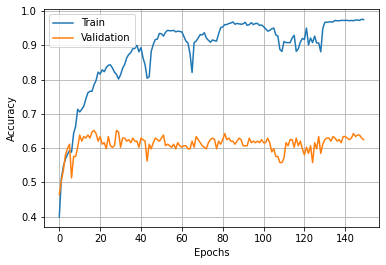

In [26]:
#Plot Accuracy
plt.plot(iTrainingAcc)
plt.plot(iValidationAcc)
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Validation'])

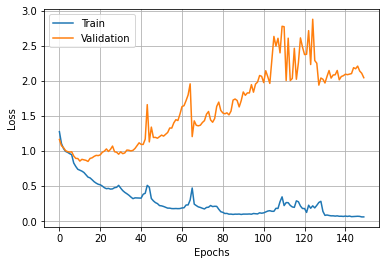

In [27]:
#Plot Loss
plt.plot(iTrainingLoss)
plt.plot(iValidationLoss)
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train','Validation'])

### Classification Report

In [28]:
print(classification_report(TestLabels, iPredLabels))

              precision    recall  f1-score   support

           0       0.84      0.76      0.80        50
           1       0.85      0.80      0.82        50
           2       0.91      0.96      0.93        50
           3       0.91      1.00      0.95        50

    accuracy                           0.88       200
   macro avg       0.88      0.88      0.88       200
weighted avg       0.88      0.88      0.88       200



### Confusion Matrix

Text(33.0, 0.5, 'Truth')

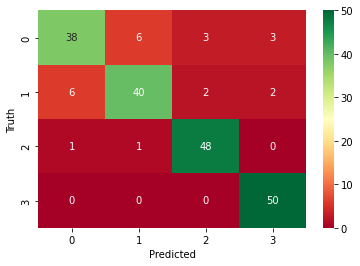

In [29]:
iConf_mat = confusion_matrix(TestLabels, iPredLabels)

sn.heatmap(iConf_mat, annot=True, cmap='RdYlGn', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')